# Ripple NRTidalv2 verification notebook

In [1]:
import psutil
p = psutil.Process()
p.cpu_affinity([0])
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta, lambdas_to_lambda_tildes
from ripple.constants import MSUN, gt, PI
from ripple.waveforms.utils_tidal import get_quadparam_octparam
from jax import grad, vmap
from functools import partial
# import importlib
# import tqdm

import lalsimulation as lalsim
import lal

from ripple import get_eff_pads

%load_ext autoreload
%autoreload 2
from ripple.waveforms import TaylorF2

params = {"axes.grid": True,
        "text.usetex" : True,
          "font.family" : "serif",
          "ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16,
          "figure.titlesize": 16}

plt.rcParams.update(params)


jax.config.update("jax_enable_x64", True) # improve precision for comparing waveforms

2024-03-08 07:18:29.116860: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/thibeau.wouters/miniconda3/envs/jim/lib/python3.10/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


Set up the comparison: first is the reference, second the other waveform, and has higher lambda

In [2]:
revert = True

m1_list = [1, 2]
m2_list = [1, 1.5]

chi1_list = [0.01, 0.01]
chi2_list = [0.01, 0.01]

lambda1_list = [0, 4000]
lambda2_list = [0, 4000]

if revert:
    m1_list = m1_list[::-1]
    m2_list = m2_list[::-1]
    chi1_list = chi1_list[::-1]
    chi2_list = chi2_list[::-1]
    lambda1_list = lambda1_list[::-1]
    lambda2_list = lambda2_list[::-1]

distance = 40.

Get the frequency grid:

In [3]:
# Frequency grid
T = 128
f_l = 20.0
f_sampling = 2 * 2048
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

## Ripple

In [4]:
hp_list = []
hx_list = []

for i in range(len(m1_list)):
    m1, m2, chi1, chi2, lambda1, lambda2 = m1_list[i], m2_list[i], chi1_list[i], chi2_list[i], lambda1_list[i], lambda2_list[i]
    
    m1_msun = m1
    m2_msun = m2
    chi1 = chi1
    chi2 = chi2
    tc = 0
    phic = 0
    dist_mpc = distance
    inclination = 0
    polarization_angle = 0.0

    # Convert from source values to sample values
    Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))
    lambda_tilde, delta_lambda_tilde = lambdas_to_lambda_tildes(jnp.array([lambda1, lambda2, m1, m2]))

    theta_ripple = jnp.array([Mc, eta, chi1, chi2, lambda_tilde, delta_lambda_tilde, dist_mpc, tc, phic, inclination])
    fs_ripple = jnp.arange(f_l, f_u, df)[1:]

    # And finally lets generate the waveform!
    hp_ripple, hc_ripple = TaylorF2.gen_TaylorF2_hphc(fs_ripple, theta_ripple, f_ref)

    hp_list.append(hp_ripple)
    hx_list.append(hc_ripple)

f = fs_ripple

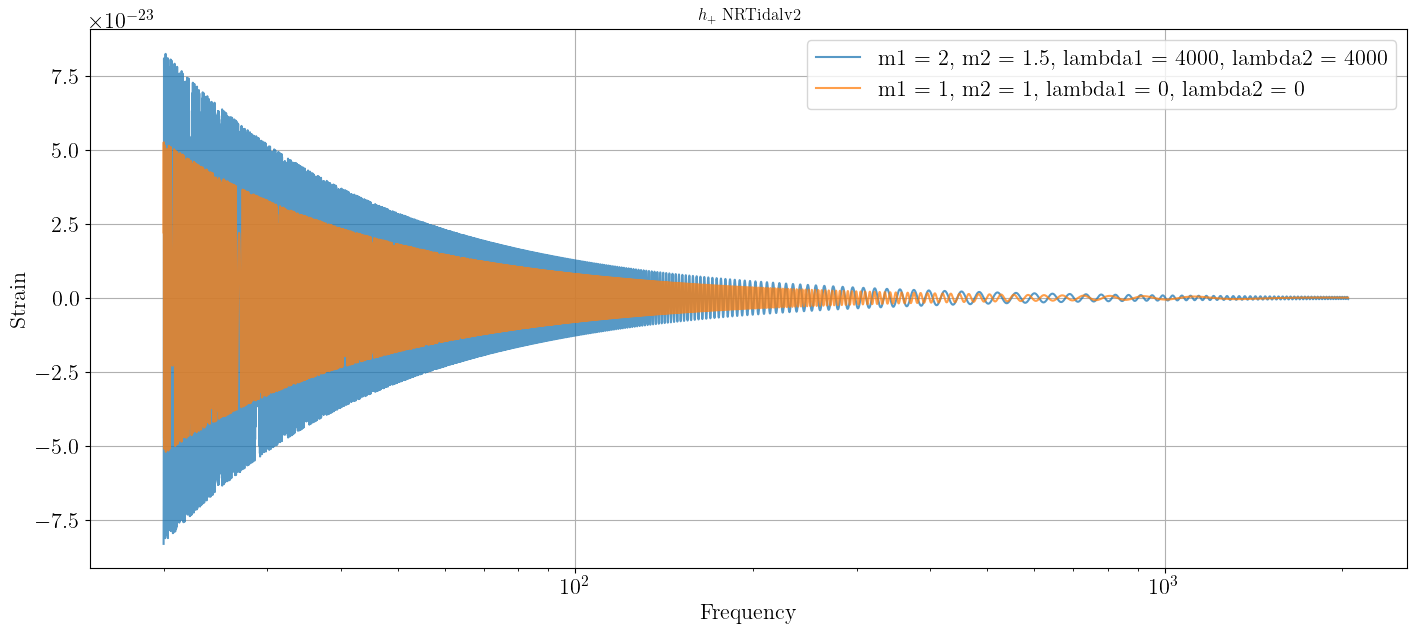

In [5]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

for i in range(len(hp_list)):
    plt.plot(f, hp_list[i].real, "-", label = f"m1 = {m1_list[i]}, m2 = {m2_list[i]}, lambda1 = {lambda1_list[i]}, lambda2 = {lambda2_list[i]}", alpha = a)

# plt.plot(f, hp_ripple.real, "-", label = "ripple", alpha = a)
plt.title(f"h+, NRTidalv2") #  lambda1, lambda2 = {lambda1, lambda2}
plt.title(r"$h_+$ NRTidalv2") #  ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2)
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.legend()
plt.show()

In [6]:
# ## Get the merger frequency to check the Planck taper window
# l1, l2 = lambda1, lambda2
# merger_params = jnp.array([m1, m2, chi1, chi2, l1, l2])

# f_merger = X_NRTidalv2._get_merger_frequency(merger_params)
# f_merger = float(f_merger)

# ## Get amplitude and angle for comparison

# A_ripple = jnp.abs(hp_ripple)
# angle_ripple = np.unwrap(np.angle(hp_ripple))
# phase_ripple = hp_ripple / A_ripple

# # Choose whether we plot the angle or the phase
# plot_angle = True

# plt.subplots(2, 1, figsize=(12, 10), sharex=True)
# plt.subplot(2, 1, 1)

# # Plot the amplitude
# plt.plot(fs_ripple, A_ripple, "--", label = "ripple")

# # Plot where the Planck taper has to take place
# plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
# plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

# plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
# plt.xlim(f_l - 5)
# plt.legend()

# # Plot the angle or the phase
# plt.subplot(2, 1, 2)
# if plot_angle:
#     plt.plot(fs_ripple, angle_ripple, "--", label = "ripple")
#     name = "Angle"
# else:
#     plt.plot(fs_ripple, phase_ripple, "--", label = "ripple")
#     name = "Phase"
# plt.legend()
# plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
# plt.xlabel("Frequency (Hz)")
# plt.ylabel(f"{name}")
# plt.xscale('log')
# plt.xlim(f_l - 5)
# plt.show()

Now plot the comparison on top of each other:

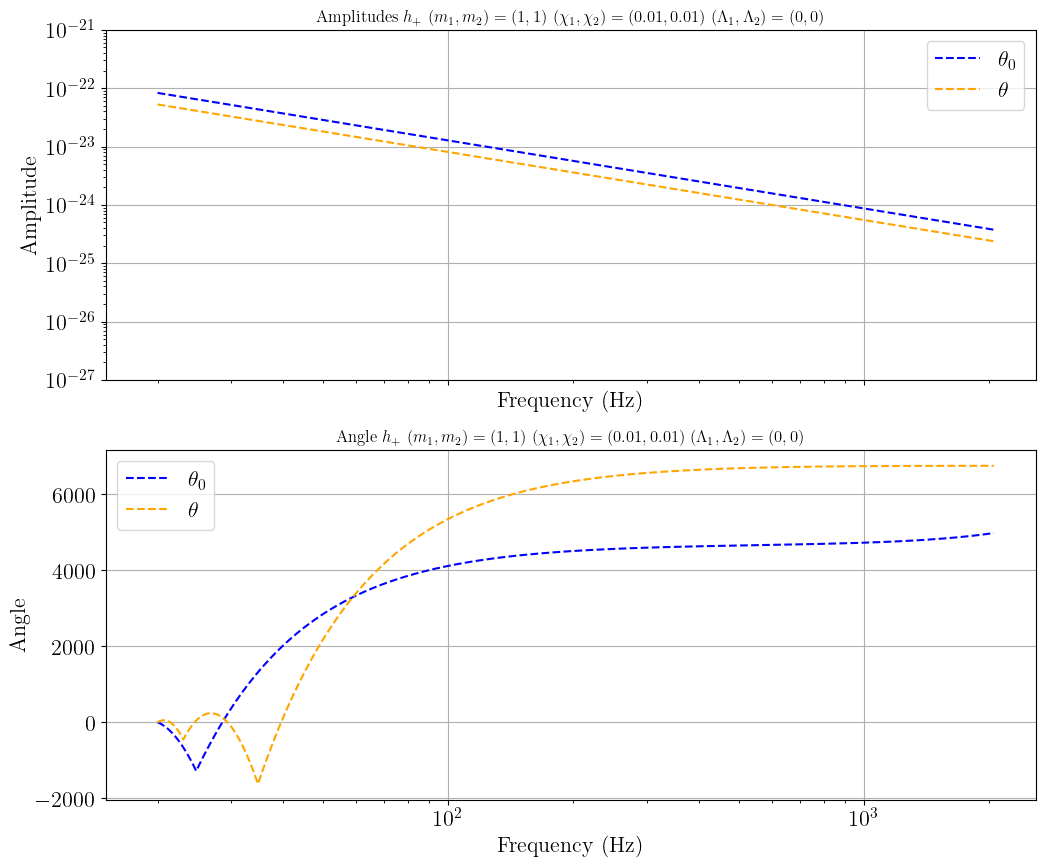

In [7]:
# Choose whether we plot the angle or the phase
plot_angle = True
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
colors = ["blue", "orange"]
labels = [r"$\theta_0$", r"$\theta$"]

for i in range(len(m1_list)):
    # Get this waveform
    c = colors[i]
    label = labels[i]
    m1, m2, chi1, chi2, lambda1, lambda2 = m1_list[i], m2_list[i], chi1_list[i], chi2_list[i], lambda1_list[i], lambda2_list[i]
    hp_ripple = hp_list[i]
    
    ## Get amplitude and angle for comparison
    A_ripple = jnp.abs(hp_ripple)
    angle_ripple = np.unwrap(np.angle(hp_ripple))
    phase_ripple = hp_ripple / A_ripple

    plt.subplot(2, 1, 1)

    # Plot the amplitude
    plt.plot(fs_ripple, A_ripple, "--", label = label, c=c)

    plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.ylim(1e-27, 1e-21)
    plt.xlim(f_l - 5)
    plt.legend()

    # Plot the angle or the phase
    plt.subplot(2, 1, 2)
    if plot_angle:
        plt.plot(fs_ripple, angle_ripple, "--", label = label, c=c)
        name = "Angle"
    else:
        plt.plot(fs_ripple, phase_ripple, "--", label = label, c=c)
        name = "Phase"
    plt.legend()
    plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(f"{name}")
    plt.xscale('log')
    plt.xlim(f_l - 5)
    
plt.show()

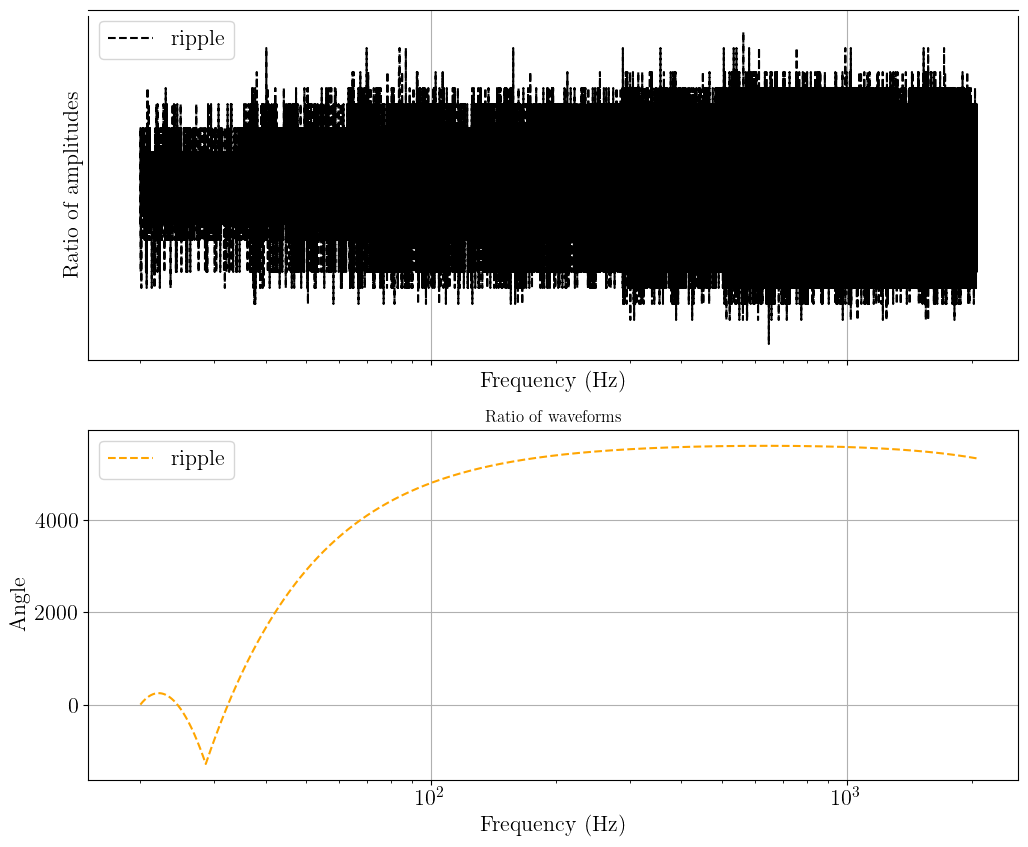

In [8]:
# Choose whether we plot the angle or the phase
plot_angle = True
plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Get this waveform
c = colors[i]
# m1, m2, chi1, chi2, lambda1, lambda2 = m1_list[i], m2_list[i], chi1_list[i], chi2_list[i], lambda1_list[i], lambda2_list[i]
hp_ripple = hp_list[i]

# ## Get the merger frequency to check the Planck taper window
# l1, l2 = lambda1, lambda2
# merger_params = jnp.array([m1, m2, chi1, chi2, l1, l2])

# f_merger = X_NRTidalv2._get_merger_frequency(merger_params)
# f_merger = float(f_merger)

## Get amplitude and angle for comparison
ratio = hp_list[1] / hp_list[0]
A_ripple_ratio = jnp.abs(ratio)
angle_ripple_ratio = np.unwrap(np.angle(ratio))
phase_ripple_ratio = ratio / A_ripple_ratio

plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(fs_ripple, A_ripple_ratio, "--", label = "ripple", c="black")

# # Plot where the Planck taper has to take place
# plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper', c=c)
# plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black', c=c)

# plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Ratio of amplitudes")
# plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(fs_ripple, angle_ripple_ratio, "--", label = "ripple", c=c)
    name = "Angle"
else:
    plt.plot(fs_ripple, phase_ripple_ratio, "--", label = "ripple", c=c)
    name = "Phase"
plt.legend()
# plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.title("Ratio of waveforms")
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)

plt.show()

In [69]:
ratio

Array([-0.16556804+0.61371799j, -0.51320873-0.37507335j,
        0.5315033 -0.34866623j, ...,         inf       -infj,
               inf       -infj,         inf       -infj],      dtype=complex128)